# Problem Set 5: APIs & SQL


Check out the in-class acitivity notebooks, lecture notebooks, and lecture slides for resources.

0.0 Import packages

**Note you need to install some of the packages imported below (see the comments).**

In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import matplotlib.pyplot as plt
import plotnine 
from plotnine import *
import yaml
#import warnings
#warnings.filterwarnings("ignore")

## note: you may need to install these packages
#! conda activate qss20
#! conda install mysql-connector-python
import mysql.connector

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

# 1. Write a wrapper function to pull data from the NAEP API (12 points)

In the class activity on APIs, we practiced pulling from the API for the National Assessment of Educational Progress (NAEP), "America's report card" of test scores. We pulled a small amount of data at the national level (writing scores by gender) using a query where the parameters were hardcoded.
    
In this problem, we'll practice pulling a larger set of data and writing a wrapper function.
    
As a reminder, the documentation is here: https://www.nationsreportcard.gov/api_documentation.aspx

The base link is: https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx

## 1.1 Write a query to pull 8th-grade mathematics scores in 2015 from the state of California (CA) by gender (1 point)

- Subject: mathematics 
- Subscale: MRPCM composite scale 
- Grade: 8
- Year: 2015
- grouping variable: GENDER 
- Jurisdiction: CA 
- stattype = MN (for mean)

Print the output in dataframe format and briefly interpret; what do scores look like between the genders?

In [2]:
# your code here
base_url = "https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx"

params = {
    "type": "data",
    "subject": "mathematics",
    "subscale": "MRPCM",
    "grade": "8",
    "Year" : "2015",
    "variable": "GENDER",
    "jurisdiction": "CA",
    "stattype" : "MN:MN"
}

response1 = requests.get(base_url, params=params)
data = response1.json()
df_2015 = pd.DataFrame(data['result'])
df_2015


gap = (df_2015.set_index("varValueLabel")["value"].loc["Male"]
       - df_2015.set_index("varValueLabel")["value"].loc["Female"])

print(gap)


,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,1,Male,275.020977,1,0
1,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,2,Female,275.638637,1,0


-0.6176606377949838


Females have around a 0.617 points higher avearge test score than men in this dataset

## 1.2 Write a query to pull 8th-grade mathematics scores in 2013, 2015, 2017, and 2019 from California by gender (1 point)

Same as 1.1 but pull the years 2013, 2015, 2017, and 2019 (search documentation for how to combine) in one query

In [3]:
# your code here
params = {
    "type": "data",
    "subject": "mathematics",
    "subscale": "MRPCM",
    "grade": "8",
    "Year" : "2013,2015,2017,2019",
    "variable": "GENDER",
    "jurisdiction": "CA",
    "stattype" : "MN:MN"
}

response2 = requests.get(base_url, params=params)
df_years = pd.DataFrame(response2.json()['result'])
df_years


,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,2,Female,274.597824,1,0
2,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,1,Male,275.020977,1,0
3,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,2,Female,275.638637,1,0
4,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,1,Male,276.608704,1,0
5,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,2,Female,276.669430,1,0
6,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,1,Male,274.511628,1,0
7,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,2,Female,276.721824,1,0


According to the output, the gender score gap at 2015 and 2017 are closer than the gender score gap in 2013 and 2019.

## 1.3 Create a line plot to show variation in the scores across years (2 points)

Using the results from 1.2, create a plot where the x axis has the year and the y axis is the math scores (`value` in dataframe), and there are separate lines/colors for male versus female students (`varValueLabel` in dataframe)

Start the limits of the y axis minimum at 272 and add informative labels. Be sure your x-axis is ticked on odd years, because NAEP scores skip even years. 

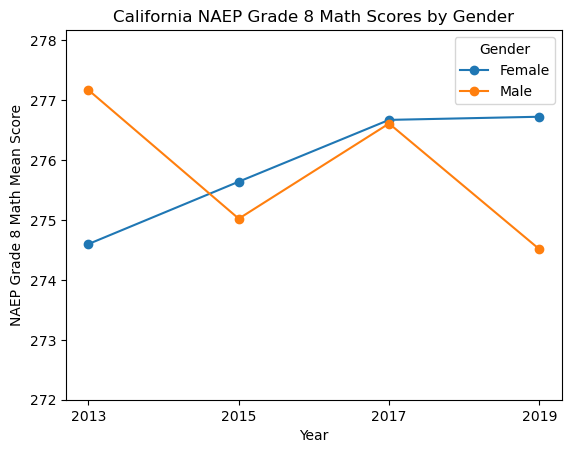

In [4]:
# your code here
plot_df = df_years[["year", "varValueLabel", "value"]].copy()
plot_df["year"] = plot_df["year"].astype(int)
plot_df["value"] = plot_df["value"].astype(float)

# _ = throwaway variable to avoid printing the plot object

for g, sub in plot_df.sort_values("year").groupby("varValueLabel"):
    _ = plt.plot(sub["year"], sub["value"], marker="o", label=g)

_ = plt.ylim(272, plot_df["value"].max() + 1)
_ = plt.xticks([2013,2015,2017,2019])
_ = plt.xlabel("Year")
_ = plt.ylabel("NAEP Grade 8 Math Mean Score")
_ = plt.title("California NAEP Grade 8 Math Scores by Gender")
_ = plt.legend(title="Gender")
plt.show()


## 1.4 Reproduce the queries from 1.1 and 1.2 using a user-defined function (4 points)

Create a function, `construct_naep_query` that takes in two arguments:

- year: this should be a list with all years (so if one year, single element list; if multiple years, list with those years)
- place: this should be a string with the name of the state or jurisdiction to pull 
    
Have the function return the query and make sure it's identical to the queries you wrote for 1.1 and 1.2 (can use assert or other checker)

In [5]:
# your code here to define function
def construct_naep_query(year, place):
    years_str = ",".join(str(y) for y in year)
    params = {
        "type": "data",
        "subject": "mathematics",
        "subscale": "MRPCM",
        "grade": "8",
        "Year" : years_str,
        "variable": "GENDER",
        "jurisdiction": place,
        "stattype" : "MN:MN"
    }
    
    request = requests.Request("GET", base_url, params=params)
    prepared = request.prepare()

    return prepared.url

In [6]:
# your code here to execute function
print(response1.url)
constructed_1 = construct_naep_query([2015], "CA")
print(constructed_1)

print(response2.url)
constructed_2 = construct_naep_query([2013, 2015, 2017, 2019], "CA")
print(constructed_2)

assert response1.url == constructed_1
assert response2.url == constructed_2

print("All assertions passed!")




https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&subscale=MRPCM&grade=8&Year=2015&variable=GENDER&jurisdiction=CA&stattype=MN%3AMN
https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&subscale=MRPCM&grade=8&Year=2015&variable=GENDER&jurisdiction=CA&stattype=MN%3AMN
https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&subscale=MRPCM&grade=8&Year=2013%2C2015%2C2017%2C2019&variable=GENDER&jurisdiction=CA&stattype=MN%3AMN
https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&subscale=MRPCM&grade=8&Year=2013%2C2015%2C2017%2C2019&variable=GENDER&jurisdiction=CA&stattype=MN%3AMN
All assertions passed!


## 1.5 Write and execute user-defined function that takes in a query and returns a pandas dataframe with the content of the response (4 points)

- Write a user-defined function (`process_naep_query`) that takes in the CA-specific NAEP query as a string, calls the API, and transforms the response into a pandas dataframe. Have the function return that pandas dataframe

- Make sure the function is flexible enough to handle queries that return an error; for queries that return an error, have the function return the string "Data not found; check your query" (see the solution for the in-class activity for API Part 1 for an example of `try:`/`except:`)

- Execute the function on the query that pulls 2013-2019 data (either from handwriting the query or the result in 1.4)

- Print the resulting dataframe

- Then execute the function on a query that pulls a state that doesn't exist (call this state ZZ)

In [7]:
# your code here
def process_naep_query(query):
    try:
        r = requests.get(query, timeout=30)
        r.raise_for_status()
        j = r.json()
        if j.get("status") != 200 or "result" not in j or len(j["result"]) == 0:
            return "Data not found. Check your query."
        return pd.DataFrame(j["result"])
    except Exception:
        return "Data not found; check your query"

df_ca_1319 = process_naep_query(constructed_2)
df_ca_1319

q_zz = construct_naep_query([2015], "ZZ")
process_naep_query(q_zz)


,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,2,Female,274.597824,1,0
2,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,1,Male,275.020977,1,0
3,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,2,Female,275.638637,1,0
4,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,1,Male,276.608704,1,0
5,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,2,Female,276.669430,1,0
6,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,1,Male,274.511628,1,0
7,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Sex,2,Female,276.721824,1,0


'Data not found; check your query'

# 2. Explore data using SQL queries (18 points)

In the previous example, you worked with the data in a flat file and manipulated it using pandas. Here, we're going to practice running queries to do some calculations using SQL --- in the case of our data, this is a bit overkill since the data are small but it is practice for larger datasets.

## 2.1 Load database credentials and establish a connection (1 point)

Prep work: Authorize connection to our own SQL database

1. Copy the credential file for the in-class activity for SQL (`lecXX_db_cred.yaml`) to the folder containing your problem set notebook
2. Rename the combined credential file something appropriate (feel free to get creative)
3. Change the database name in the credential file from `sentencing` to `math_gencompare` to connect to the `math_gencompare` database
4. Load the credential file.  You'll need it to connect to the `math_gencompare` database (see how to do this in the activity for SQL)

Note: To establish the SQL connection, you need to be on `eduroam` (near campus) or the Dartmouth's GlobalProtect VPN  ([installation instructions here](https://services.dartmouth.edu/TDClient/1806/Portal/KB/ArticleDet?ID=72395))

In [8]:
creds = load_creds("pset5_db_cred.yaml")

cnx = mysql.connector.connect(
    host=creds["practice_database"]["host"],
    user=creds["practice_database"]["user"],
    password=creds["practice_database"]["password"],
    database=creds["practice_database"]["database"],
    port=creds["practice_database"].get("port", 3306)
)

## 2.2 Run a query to select all columns and the first 5 rows of the math_gencompare database to explore structure (2 points)

Read the results in as a pandas dataframe and print the result

In [9]:
# your code here
q = """
SELECT * FROM math_gencompare 
LIMIT 5;
"""
result = pd.read_sql_query(q, cnx)
result

C:\Users\sharp\AppData\Local\Temp\ipykernel_29728\2439259322.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,abbrev,FIPS,state,year,female,male
0,AK,2,Alaska,2013,281.388243030547,281.723376175464
1,AL,1,Alabama,2013,268.920111754346,269.457455785562
2,AR,5,Arkansas,2013,278.381788404903,277.457662328569
3,AZ,4,Arizona,2013,279.249581150207,280.174388600923
4,CA,6,California,2013,274.597823860242,277.167170641967


## 2.3 Find the (1) number of rows in the database, (2) number of distinct states,  (3) number of distinct years (3 points)

Interpret the results - how do you think the data is structured in terms of states and years (eg long format where each state repeated; wide format)?

**Hint**: rather than using count `(*)` for the latter two, think about the `distinct` command in combination with `count`: https://www.w3resource.com/mysql/aggregate-functions-and-grouping/aggregate-functions-and-grouping-count-with-distinct.php

In [10]:
# your code here
q = """
SELECT
  COUNT(*) AS n_rows,
  COUNT(DISTINCT state) AS n_states,
  COUNT(DISTINCT year) AS n_years
FROM math_gencompare;
"""

counts = pd.read_sql_query(q, cnx)
counts

C:\Users\sharp\AppData\Local\Temp\ipykernel_29728\3883268936.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,n_rows,n_states,n_years
0,200,50,4


Since n_rows = n_states * n_years, the data is structured in a long format where each state is repeated per year.

## 2.4 Construct a new variable, `is_male_higher` that takes the value of 1 if the math scores of males exceed that of females in that state and year (each row) (2 points)

Read in the results, print the head, and find the mean across all rows (the percentage of state-years where male students have higher scores)

In [11]:
# your code here
q = """
SELECT *,
  CASE WHEN male > female THEN 1 ELSE 0 END AS is_male_higher
FROM math_gencompare;
"""
male_higher_result = pd.read_sql_query(q, cnx)
male_higher_result.head()

male_higher_result["is_male_higher"].mean()


C:\Users\sharp\AppData\Local\Temp\ipykernel_29728\312158672.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,abbrev,FIPS,state,year,female,male,is_male_higher
0,AK,2,Alaska,2013,281.388243030547,281.723376175464,1
1,AL,1,Alabama,2013,268.920111754346,269.457455785562,1
2,AR,5,Arkansas,2013,278.381788404903,277.457662328569,0
3,AZ,4,Arizona,2013,279.249581150207,280.174388600923,1
4,CA,6,California,2013,274.597823860242,277.167170641967,1


np.float64(0.515)

51.5% of rows in the dataset has a higher avg test score for males than females

## 2.5 group by year and find the percentage of states where male scores are higher than females (4 points)

**A.** Write a query that (1) groups by year and (2) finds the percentage of states that have higher scores for males than females in this year 

**B.** Print the resulting dataframe and interpret the results 

**Hint:** To compare male and female scores, consider logical operators (e.g., `<`, `>`, `=`) and simple aggregation (e.g., `avg()` to get mean) or using a subquery to construct the indicator.

In [12]:
# your code here
q = """
SELECT year,
  AVG(CASE WHEN male > female THEN 1 ELSE 0 END) AS pct_male_higher
FROM math_gencompare
GROUP BY year
ORDER BY year;
"""
by_year = pd.read_sql_query(q, cnx)
by_year


C:\Users\sharp\AppData\Local\Temp\ipykernel_29728\3825439572.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,year,pct_male_higher
0,2013,0.62
1,2015,0.56
2,2017,0.58
3,2019,0.30


2013, 2015, and 2017 are years where over 50% of states had a higher male test score than female test score (~56%-62%)

## 2.6 group by state and find the percentage of years where male scores higher than females

**A.** Write a query that (1) groups by state and (2) finds the percentage of years that have higher scores for males than females in that state

**B.** Plot the results ordering the states from males higher all 4 years to males higher none of the years

C:\Users\sharp\AppData\Local\Temp\ipykernel_29728\2324371700.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,state,pct_years_male_higher
0,Idaho,1.00
1,Illinois,1.00
2,Utah,1.00
3,Alaska,0.75
4,Arizona,0.75
5,Colorado,0.75
6,Florida,0.75
7,Georgia,0.75
8,Indiana,0.75
9,Kansas,0.75


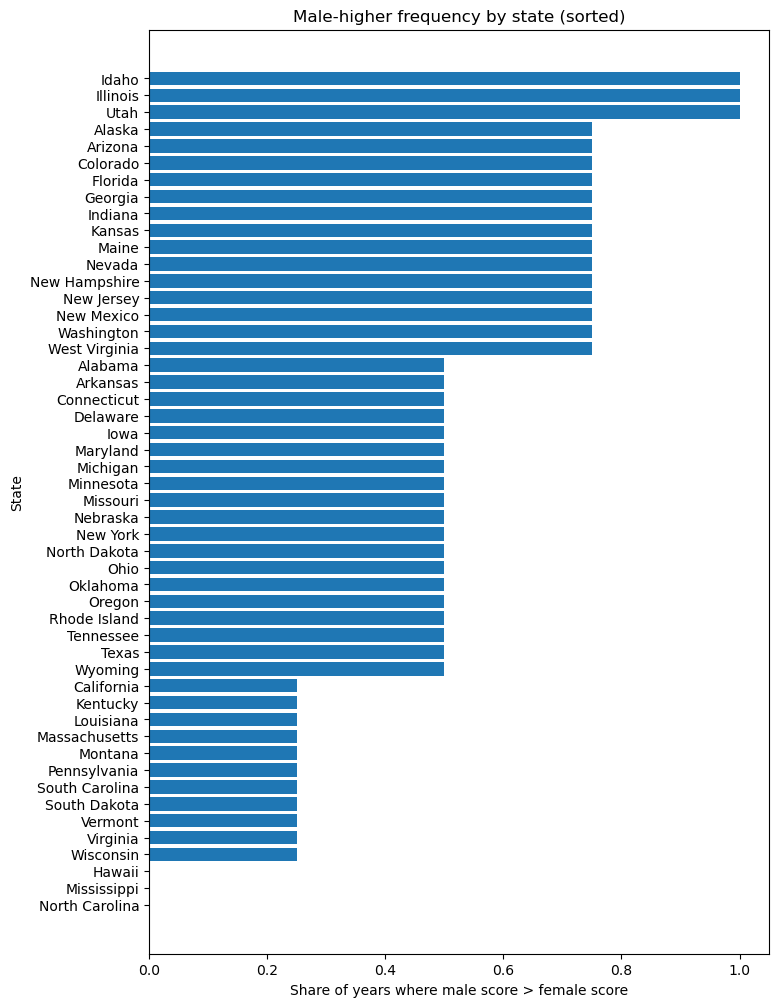

In [13]:
# your code here
q = """
SELECT state,
    AVG(CASE WHEN male > female THEN 1 ELSE 0 END) AS pct_years_male_higher
FROM math_gencompare
GROUP BY state
ORDER BY pct_years_male_higher DESC, state;
"""

by_state = pd.read_sql_query(q, cnx)
by_state

plot_by_state = by_state.sort_values("pct_years_male_higher", ascending=False)

_ = plt.figure(figsize=(8,12))
_ = plt.barh(plot_by_state["state"], plot_by_state["pct_years_male_higher"])
_ = plt.xlabel("Share of years where male score > female score")
_ = plt.ylabel("State")
_ = plt.title("Male-higher frequency by state (sorted)")
_ = plt.gca().invert_yaxis()
plt.show()


## 2.7 Use a subquery to create an indicator and group by that indicator (6 points)

The following states were the first 6 to expand the right to vote to women before the uniform federal expansion in 1920

- Wyoming 1890
- Colorado 1893
- Utah 1896
- Idaho 1896
- Washington 1910
- California 1911

**A.** Create an indicator `is_early_voter` for whether a state is in that list or not; do so without typing the state names inside the string and instead collapsing the list of states we provide and using something like `format`. Hint on how to combine the state names while preserving the quotes around each: https://stackoverflow.com/questions/12007686/join-a-list-of-strings-in-python-and-wrap-each-string-in-quotation-marks 

**B.** Then, group by the `is_early_voter` indicator and `year` and find the percencentage of states in each group where males had higher scores than females 

**C.** Print the resulting dataframe and interpret. Does early expansion of voting seem to be correlated with girls scoring better on the math tests a century later?

**Hint:** in order to group by the indicator in step b, you may need to use a subquery 

In [14]:
## list of states we provide
list_suffrage = ["Wyoming", "Colorado", "Utah", "Idaho", "Washington", 
                "California"]

In [15]:
## your code here
list_suffrage_sql = ",".join([f"'{s}'" for s in list_suffrage])
list_suffrage_sql

q = f"""
SELECT
  is_early_voter,
  year,
  AVG(is_male_higher) AS pct_male_higher
FROM (
  SELECT
    state,
    year,
    CASE WHEN state IN ({list_suffrage_sql}) THEN 1 ELSE 0 END AS is_early_voter,
    CASE WHEN male > female THEN 1 ELSE 0 END AS is_male_higher
  FROM math_gencompare
) temp
GROUP BY is_early_voter, year
ORDER BY year, is_early_voter;
"""
early_suffrage_gap = pd.read_sql_query(q, cnx)
early_suffrage_gap

early_suffrage_gap.groupby("is_early_voter")["pct_male_higher"].mean()




"'Wyoming','Colorado','Utah','Idaho','Washington','California'"

C:\Users\sharp\AppData\Local\Temp\ipykernel_29728\527934855.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


,is_early_voter,year,pct_male_higher
0,0,2013,0.5909
1,1,2013,0.8333
2,0,2015,0.5455
3,1,2015,0.6667
4,0,2017,0.5455
5,1,2017,0.8333
6,0,2019,0.2727
7,1,2019,0.5000


is_early_voter
0    0.488650
1    0.708325
Name: pct_male_higher, dtype: float64

According to the dataset, the early-sufferage states have a higher pct_male_higher than other states, meaning males more often score higher than females in that group. Hence early expansion of women's voting rights does not appear correlated with girls scoring better on NAEP math a century later.